In [1]:
!git clone https://github.com/timesler/facenet-pytorch.git 

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1261, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1261 (delta 10), reused 8 (delta 2), pack-reused 1235
Receiving objects: 100% (1261/1261), 22.88 MiB | 38.67 MiB/s, done.
Resolving deltas: 100% (612/612), done.


**Rename to facenet_pytorch**

In [3]:
%cd /content/facenet_pytorch

/content/facenet_pytorch


# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [24]:
from facenet_pytorch.models.mtcnn import MTCNN
from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [6]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [7]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [10]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/facenet_pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [11]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [12]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [13]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  ...  paul_rudd  shea_whigham
angelina_jolie        0.000000        1.447480  ...   1.429847      1.399073
bradley_cooper        1.447480        0.000000  ...   1.013447      1.038684
kate_siegel           0.887728        1.313749  ...   1.388377      1.379655
paul_rudd             1.429847        1.013447  ...   0.000000      1.100503
shea_whigham          1.399073        1.038684  ...   1.100503      0.000000

[5 rows x 5 columns]


In [16]:
!pip install mmcv

     |████████████████████████████████| 296kB 6.6MB/s 
     |████████████████████████████████| 194kB 9.5MB/s 
  Created wheel for mmcv: filename=mmcv-1.3.4-py2.py3-none-any.whl size=426558 sha256=04756933d3b8d37185c73a1ed5f3d9bf5f340e0a749601a1755d73d8446e079b
  Stored in directory: /root/.cache/pip/wheels/c3/69/33/1c007e7c0484c8312523cb1beb2af0f10c99d8b08369b81ae2
Successfully built mmcv


In [21]:
import cv2
import mmcv
from PIL import Image, ImageDraw
from IPython import display

In [28]:
video = mmcv.VideoReader('/content/facenet_pytorch/examples/video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

#display.Video('video.mp4', width=640)

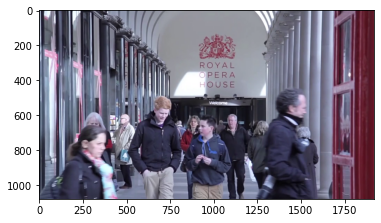

In [25]:
plt.imshow(frames[0])

In [26]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 105
Done


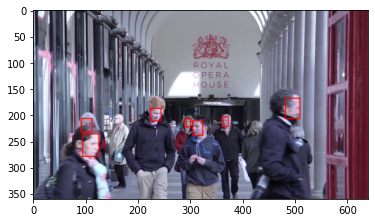

In [27]:
plt.imshow(frames_tracked[0])